In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

rsna_pneumonia_detection_challenge_path = kagglehub.competition_download('rsna-pneumonia-detection-challenge')

print('Data source import complete.')


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

2025-06-26 14:40:02.876072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750948803.084920      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750948803.147442      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
IMG_SIZE = 227
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-5

DICOM_DATA_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
LABELS_CSV = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
PNG_OUTPUT_DIR = "/kaggle/working/rsna_pneumonia_png_images"

In [ ]:
os.makedirs(PNG_OUTPUT_DIR, exist_ok=True) # Çıktı dizinini oluştur

# Etiket DataFrame'ini yükle
df_labels = pd.read_csv(LABELS_CSV)
patient_ids = df_labels['patientId'].unique()

print(f"{len(patient_ids)} adet DICOM dosyası PNG'ye dönüştürülüyor...")

for i, patient_id in enumerate(patient_ids):
    dicom_path = os.path.join(DICOM_DATA_DIR, patient_id + ".dcm")
    output_path = os.path.join(PNG_OUTPUT_DIR, patient_id + ".png")

    # Eğer dosya zaten dönüştürülmüşse atla
    if os.path.exists(output_path):
        continue

    try:
        dicom = pydicom.dcmread(dicom_path)
        img = dicom.pixel_array.astype(np.float32)

        # DICOM Pencereleme Uygula
        if 'WindowCenter' in dicom and 'WindowWidth' in dicom:
            window_center = dicom.WindowCenter
            window_width = dicom.WindowWidth

            # Birden fazla pencere ayarı varsa ilkini kullan
            if isinstance(window_center, pydicom.multival.MultiValue):
                window_center = window_center[0]
            if isinstance(window_width, pydicom.multival.MultiValue):
                window_width = window_width[0]

            min_val = window_center - window_width / 2
            max_val = window_center + window_width / 2

            img = np.clip(img, min_val, max_val)
            # 0-255 aralığına ölçekle (PNG olarak kaydetmek için)
            img = ((img - min_val) / (max_val - min_val + 1e-5)) * 255
        else:
            # Pencere bilgisi yoksa veya tanımsızsa basit min-max normalizasyona geri dön
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5) * 255

        img = img.astype(np.uint8)

        # Görüntüyü yeniden boyutlandır
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # PNG olarak kaydet
        cv2.imwrite(output_path, img)

    except Exception as e:
        print(f"Hata: {patient_id}.dcm dönüştürülürken hata oluştu: {e}")
        continue

    if (i + 1) % 1000 == 0:
        print(f"{i + 1} görüntü dönüştürüldü.")

print("Tüm DICOM dosyaları PNG'ye dönüştürüldü.")

26684 adet DICOM dosyası PNG'ye dönüştürülüyor...
1000 görüntü dönüştürüldü.
2000 görüntü dönüştürüldü.
3000 görüntü dönüştürüldü.
4000 görüntü dönüştürüldü.
5000 görüntü dönüştürüldü.
6000 görüntü dönüştürüldü.
7000 görüntü dönüştürüldü.
8000 görüntü dönüştürüldü.
9000 görüntü dönüştürüldü.
10000 görüntü dönüştürüldü.
11000 görüntü dönüştürüldü.
12000 görüntü dönüştürüldü.
13000 görüntü dönüştürüldü.
14000 görüntü dönüştürüldü.
15000 görüntü dönüştürüldü.
16000 görüntü dönüştürüldü.
17000 görüntü dönüştürüldü.
18000 görüntü dönüştürüldü.
19000 görüntü dönüştürüldü.
20000 görüntü dönüştürüldü.
21000 görüntü dönüştürüldü.
22000 görüntü dönüştürüldü.
23000 görüntü dönüştürüldü.
24000 görüntü dönüştürüldü.
25000 görüntü dönüştürüldü.
26000 görüntü dönüştürüldü.
Tüm DICOM dosyaları PNG'ye dönüştürüldü.


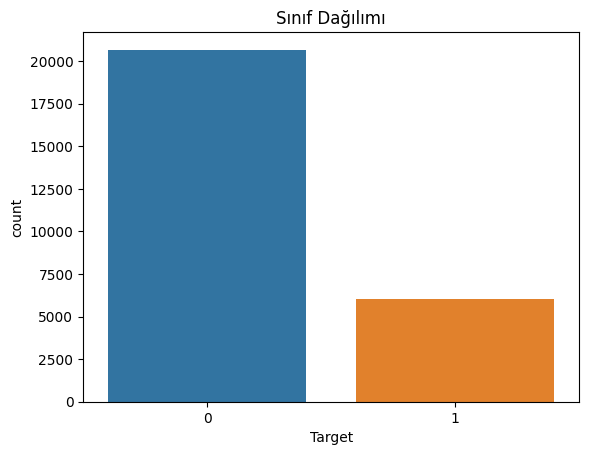

In [ ]:
df = pd.read_csv(LABELS_CSV)
df = df.drop_duplicates(subset="patientId")[['patientId', 'Target']]
df["filename"] = df["patientId"] + ".png"

sns.countplot(x=df["Target"])
plt.title("Sınıf Dağılımı")
plt.show()

In [ ]:
# Eğitim-Doğrulama-Test Ayırma
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Target"], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df["Target"], random_state=42)

train_df['Target'] = train_df['Target'].astype(str)
val_df['Target'] = val_df['Target'].astype(str)
test_df['Target'] = test_df['Target'].astype(str)

print(f"Eğitim seti boyutu: {len(train_df)}")
print(f"Doğrulama seti boyutu: {len(val_df)}")
print(f"Test seti boyutu: {len(test_df)}")

Eğitim seti boyutu: 19212
Doğrulama seti boyutu: 2135
Test seti boyutu: 5337


In [ ]:
# Sınıf ağırlıkları
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df["Target"]), y=train_df["Target"])
class_weights = dict(enumerate(class_weights))
print("Sınıf Ağırlıkları (Class Weights):", class_weights)

Sınıf Ağırlıkları (Class Weights): {0: 0.6454343882281798, 1: 2.218988218988219}


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,       # Maksimum 15 derece döndürme
    zoom_range=0.15,         # %15'e kadar yakınlaştırma
    width_shift_range=0.1,   # %10 genişlik kaydırma
    height_shift_range=0.1,  # %10 yükseklik kaydırma
    horizontal_flip=True,    # Yatay çevirme
    fill_mode='nearest'      # Boş kalan pikselleri en yakın değerle doldur
)

# Doğrulama ve test için sadece yeniden ölçeklendirme yapılır, veri artırma uygulanmaz.
val_test_datagen = ImageDataGenerator(rescale=1./255)

# GENERATORLAR (flow_from_dataframe kullanılarak)
# directory: Dönüştürülmüş PNG'lerin bulunduğu dizini gösterir.
# x_col: DataFrame'deki dosya adlarını içeren sütun adı.
# y_col: DataFrame'deki etiketleri içeren sütun adı.
# target_size: Görüntülerin yeniden boyutlandırılacağı hedef boyut.
# class_mode: İkili sınıflandırma (0 veya 1) olduğu için 'binary'.
# color_mode: AlexNet 3 kanal beklediği için 'rgb' kullanıldı. Gri tonlamalı PNG'leri 3 kanala kopyalayacak.
# shuffle: Eğitim ve doğrulama için karıştırma açılır, test için kapatılır.

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=PNG_OUTPUT_DIR,
    x_col="filename",
    y_col="Target",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=PNG_OUTPUT_DIR,
    x_col="filename",
    y_col="Target",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False # Doğrulama için karıştırma kapalı
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=PNG_OUTPUT_DIR,
    x_col="filename",
    y_col="Target",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False # Test için karıştırma kapalı (önemli: y_true ile eşleşmesi için)
)

Found 19212 validated image filenames belonging to 2 classes.
Found 2135 validated image filenames belonging to 2 classes.
Found 5337 validated image filenames belonging to 2 classes.


In [ ]:

def build_alexnet_classic(input_shape=(227, 227, 3)):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=2),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid', dtype='float32')  # İkili sınıflandırma için sigmoid
    ])

    return model

model = build_alexnet_classic()
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1750949533.779747      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, # Öğrenme oranını %20'ye düşür
                               patience=3,
                               min_lr=1e-7,
                               verbose=1)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1750949540.679488     102 service.cc:148] XLA service 0x7fd77c00fc20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750949540.680295     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750949541.190624     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/601 ━━━━━━━━━━━━━━━━━━━━ 1:50:53 11s/step - accuracy: 0.3750 - loss: 0.6908

I0000 00:00:1750949547.249296     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


601/601 ━━━━━━━━━━━━━━━━━━━━ 251s 400ms/step - accuracy: 0.6654 - loss: 0.6493 - val_accuracy: 0.7461 - val_loss: 0.5230 - learning_rate: 1.0000e-05
Epoch 2/15
601/601 ━━━━━━━━━━━━━━━━━━━━ 243s 404ms/step - accuracy: 0.7176 - loss: 0.5617 - val_accuracy: 0.7705 - val_loss: 0.4932 - learning_rate: 1.0000e-05
Epoch 3/15
601/601 ━━━━━━━━━━━━━━━━━━━━ 241s 401ms/step - accuracy: 0.7255 - loss: 0.5541 - val_accuracy: 0.7677 - val_loss: 0.4936 - learning_rate: 1.0000e-05
Epoch 4/15
601/601 ━━━━━━━━━━━━━━━━━━━━ 237s 394ms/step - accuracy: 0.7316 - loss: 0.5447 - val_accuracy: 0.7621 - val_loss: 0.5093 - learning_rate: 1.0000e-05
Epoch 5/15
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7272 - loss: 0.5535
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
601/601 ━━━━━━━━━━━━━━━━━━━━ 240s 400ms/step - accuracy: 0.7272 - loss: 0.5535 - val_accuracy: 0.7194 - val_loss: 0.5699 - learning_rate: 1.0000e-05
Epoch 6/15
601/601 ━━━━━━━━━━━━━━━━━━━━ 228s 379ms/step -

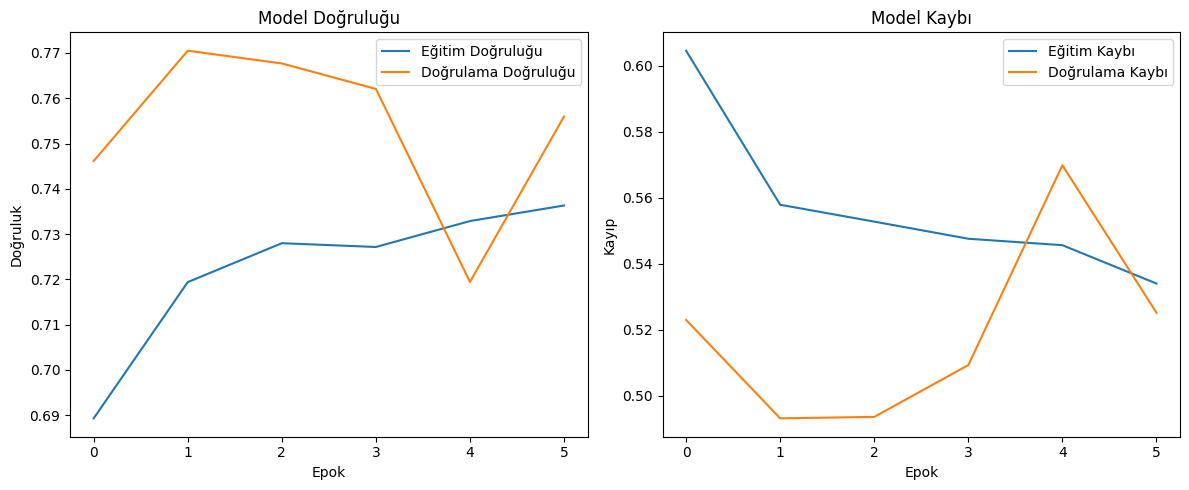

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend()
plt.title("Model Doğruluğu")
plt.xlabel("Epok")
plt.ylabel("Doğruluk")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.title("Model Kaybı")
plt.xlabel("Epok")
plt.ylabel("Kayıp")

plt.tight_layout()
plt.show()

In [ ]:
test_steps = int(np.ceil(len(test_df) / BATCH_SIZE))
y_pred_probs = model.predict(test_gen, steps=test_steps)
y_pred = (y_pred_probs > 0.6).astype(int).flatten()
y_true = test_gen.labels[:len(y_pred)]

# Karışıklık Matrisi
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
f1 = f1_score(y_true, y_pred)

print(pd.DataFrame({
    "Metrik": ["Doğruluk (Accuracy)", "Kesinlik (Precision)", "Duyarlılık (Sensitivity)", "Özgüllük (Specificity)", "F1 Skoru"],
    "Değer": [accuracy, precision, sensitivity, specificity, f1]
}))

167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step
                     Metrik     Değer
0       Doğruluk (Accuracy)  0.794829
1      Kesinlik (Precision)  0.540500
2  Duyarlılık (Sensitivity)  0.594010
3    Özgüllük (Specificity)  0.853204
4                  F1 Skoru  0.565993


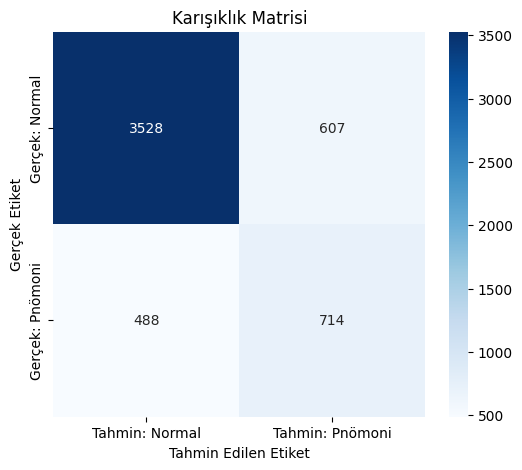

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tahmin: Normal', 'Tahmin: Pnömoni'],
            yticklabels=['Gerçek: Normal', 'Gerçek: Pnömoni'])
plt.title("Karışıklık Matrisi")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.show()